[View in Colaboratory](https://colab.research.google.com/github/DeboraID/House_Pricing/blob/master/House_Price_Pred.ipynb)

#Kaggle Install

In [0]:
# install kaggle cli
 !pip install kaggle-cli

In [0]:
# download competition files from kaggle
 !kg download -u XXXXX  -p XXXXX -c house-prices-advanced-regression-techniques

  

/usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/data_description.txt

data_description.txt already downloaded !
downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv.gz

train.csv.gz already downloaded !
downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

In [0]:
 # see a list of all files
 !ls

data_description.txt  sample_submission.csv	test.csv     train.csv
sample_data	      sample_submission.csv.gz	test.csv.gz  train.csv.gz


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import pipeline
from sklearn import decomposition
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

#  House price predict (Regression)

## Upload Data

In [0]:
train = pd.read_csv("train.csv", index_col = 'Id')
train.shape # (1460,80)
train.head(6)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000


## Simple model as baseline

we'll take only the **numeric** features and use simple regression model with no regularization and or hyper-parameters optimization

In [0]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [0]:
#choose only the number features in order 
# to calculate a baseline for the start
train_numeric = train.select_dtypes(include='number').dropna()
print(train_numeric.shape, train.shape)

(1121, 37) (1460, 80)


In [0]:
model = linear_model.Lasso(alpha=100)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(f'train rmse = {rmsle(y_train, y_train_pred.round(2)):.5f}; test rmse = {rmsle(y_test, y_test_pred):.5f}')

train rmse = 0.20243; test rmse = 0.17360


---
---
## Data Exploration

In [0]:
target = 'SalePrice'

### Numeric features


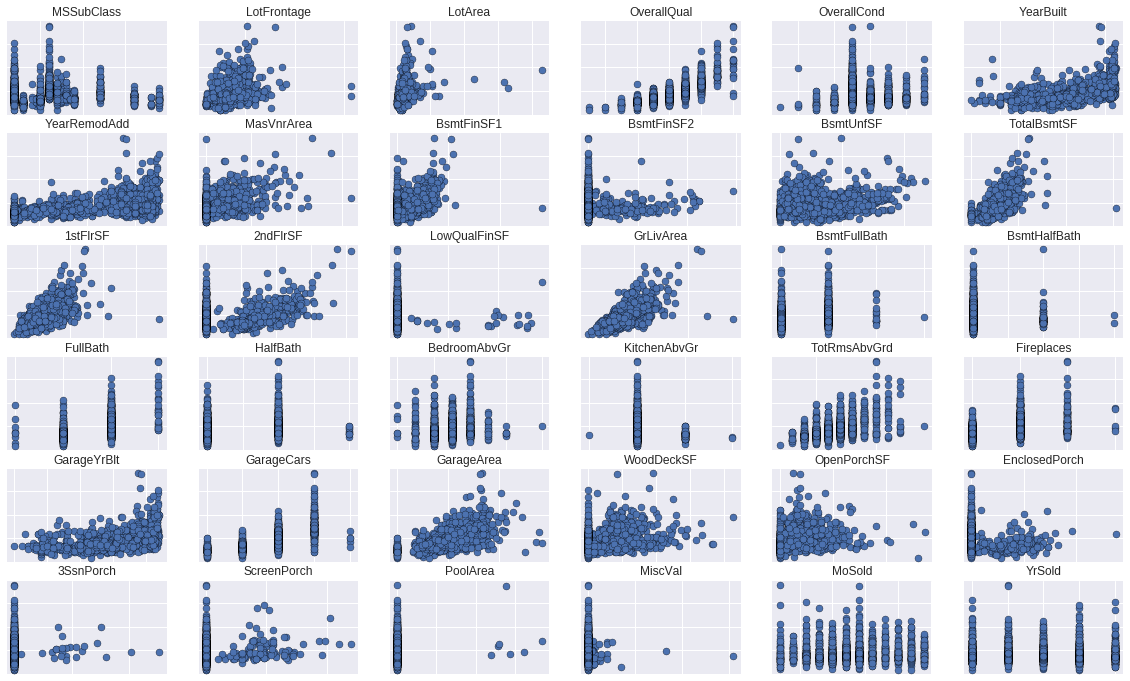

In [0]:
train_numeric = train.drop(columns=target).select_dtypes(include='number')
fig = plt.figure(figsize=(20,12))
for i in range(0,36):
    ax = fig.add_subplot(6,6,i+1)
    ax.scatter(x=train_numeric.iloc[:,i], y=train[target], edgecolor='k')
    ax.set_title(train_numeric.columns[i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

### Categorical features

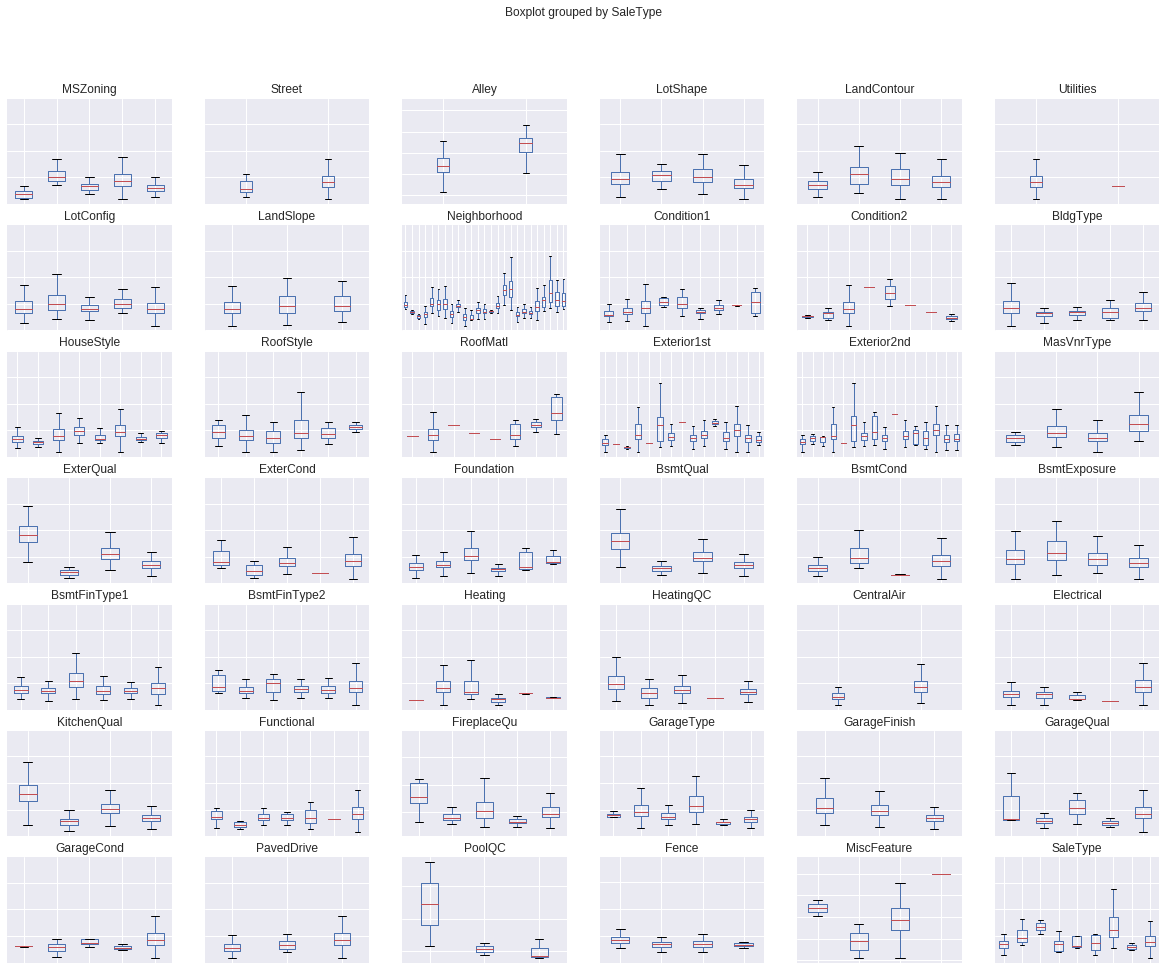

In [0]:
train_cat = train.drop(columns=target).select_dtypes(exclude='number')
train_cat.shape
fig = plt.figure(figsize=(20,16))
for i in range(0,42):
    ax = fig.add_subplot(7,6,i+1)
    col = train_cat.columns[i]
    train.boxplot(column=target, by=col, ax=ax)
    ax.set_title(col)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')

### Individual Numeric features

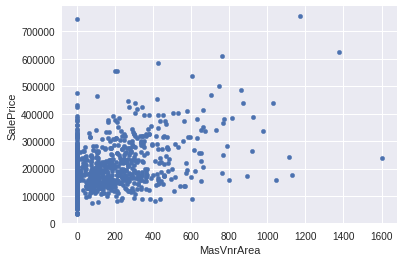

In [0]:
var = 'MasVnrArea'
train.MasVnrArea.fillna(train.MasVnrArea.mean(), inplace=True)
train.plot.scatter(x=var, y=target)

### Individual Categorical features

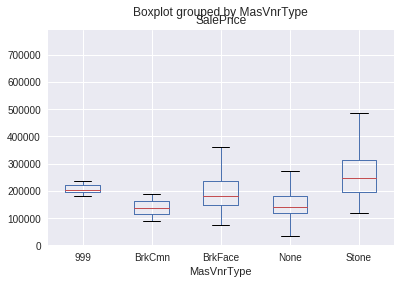

In [0]:
var = 'MasVnrType'
train2 = train[[target, var]]
train2[var] = train2[var].fillna('999')
# mask = train2.FireplaceQu.isin(['TA', 'Gd', 'Ex'])
# train2.loc[mask, var] = 'NewGroup'
# train2.info()
train2.boxplot(column=target, by=var)

In [0]:
train.groupby(by='MasVnrType')['MasVnrArea'].agg(lambda grp: grp.isna().sum())

MasVnrType
BrkCmn     0.0
BrkFace    0.0
None       0.0
Stone      0.0
Name: MasVnrArea, dtype: float64

In [0]:
X = train_numeric.drop(columns='SalePrice')
y = train_numeric['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

((784, 36), (337, 36))

## 2- Data Manipulation - Missing Values  ##

In [0]:
train_null = (train.isna().sum()/train.isna().count()).round(3).to_frame('na_portion').assign(left=train.isna().count()-train.isna().sum()).assign(dtype = train.dtypes).sort_values(by='na_portion', ascending=False).head(20)
train_null


,na_portion,left,dtype
MSSubClass,0.0,1460,int64
MSZoning,0.0,1460,object
GarageYrBlt,0.0,1460,object
GarageType,0.0,1460,object
FireplaceQu,0.0,1460,object
Fireplaces,0.0,1460,int64
Functional,0.0,1460,object
TotRmsAbvGrd,0.0,1460,int64
KitchenQual,0.0,1460,object
KitchenAbvGr,0.0,1460,int64


**Business Question for data manipulation**

*   Have  the features with a high percent of missing value an important mening ? Can we drop  them?
*   What should be the threshold for removing columns? 
Are Garage and Bsm features needed for the model ? or can we keep only one feature instead? 
in this case, what should be the best way? drop them and keep only some boolean field or creating some CPA fields for all of them ?

**for the sake of this sample i'll treat the missing values as all of them are valiable and then i'll drop the ones with missing meaning (at my point of view) forthe model **

In [0]:
missing = train.isnull().sum()
missing[missing>0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [0]:
# for Garage fields
# where 'GarageType' is null fill the related  fields with "nonGarage" / 0  
print([col for col in train.columns if 'Garage' in col])
print(len([col for col in train.columns if 'Garage' in col]))

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
7


In [0]:
#update NaN values 
train.loc[train.GarageType.isna(), 'GarageType']= 'NoGarage'
train.loc[train.GarageType == 'NoGarage', 'GarageYrBlt'] = 'NoGarage'
train.loc[train.GarageType == 'NoGarage', 'GarageQual'] = 'NoGarage'
train.loc[train.GarageType == 'NoGarage', 'GarageFinish'] = 'NoGarage'
train.loc[train.GarageType == 'NoGarage', 'GarageCond'] = 'NoGarage'
train.loc[train.GarageType == 'NoGarage', 'GarageCars'] = 0
train.loc[train.GarageType == 'NoGarage', 'GarageArea'] = 0

# missing.loc[train.isnull().sum() > 0].sort_values(ascending = False)

In [0]:
# for Basement fields
# where 'TotalBsmtSF' is null fill the related  fields with "nonBsm" / 0  
print([col for col in train.columns if 'Bsm' in col])
print(len([col for col in train.columns if 'Bsm' in col]))

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
11


In [0]:
#update NaN values 
train.loc[train.TotalBsmtSF.isna(), 'TotalBsmtSF' ]= 'NoBsmt'
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtCond'] = 'NoBsmt'
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtExposure'] = 'NoBsmt'
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtFinType1'] = 'NoBsmt'
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtFinType2'] = 'NoBsmt'
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtFinSF1'] = 0
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtFinSF2'] = 0
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtUnfSF'] = 0
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtQual'] = 0
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtFullBath'] = 0
train.loc[train.BsmtQual == 'NoBsmt', 'BsmtHalfBath'] = 0

# missing.loc[train.isnull().sum() > 0].sort_values(ascending = False)

In [0]:
# 0 Fireplace meaning that there aren't any of them 
train.loc[train.Fireplaces == 0, 'FireplaceQu'] = 'NoFireplace'

In [0]:
# for the rest of non numeric variables 
#update NaN values 

train = train.fillna({
    'Alley' : 'NoAlley',
    'PoolQC' : 'NoPool',
    'Fence' : 'NoFence',
    'MiscFeature' : 'None',
    'SaleCondition': 'Normal',
    'SaleType' : 'WD',
    
    })

# missing.loc[train.isnull().sum() > 0].sort_values(ascending = False)

In [0]:
#update LotFrontage with the mean of the Neighborhood

# # Check the data before the update
# train.iloc[1450] #-- NAmes -- 60
# train.iloc[50] #-- Gilbert -- NaN
# train.iloc[51] #-- BrkSide -- 52

avg_LotFrontage = train.groupby(['Neighborhood'])['LotFrontage'].agg(['mean','count'])
merged = train.merge(avg_LotFrontage, on=['Neighborhood'], how='left')

# #update
train.LotFrontage = merged['mean'].where(train.LotFrontage.isna(), train.LotFrontage)


# # Check the data after the update
# train.iloc[1450] #-- NAmes -- 60
# train.iloc[50] #-- Gilbert -- NaN
# train.iloc[51] #-- BrkSide -- 52
# train.loc[train.Neighborhood.isnull()]



KeyError: ignored

In [0]:
#Update the rest of data type NaN values 
train = train.fillna({
    'BsmtFinSF1': 0,
    'BsmtFinSF2': 0,
    'BsmtUnfSF': 0,
    'TotalBsmtSF': 0,
    'GarageCars': 0,
    'GarageArea': 0,
    'MasVnrArea' : 0,
    'LotArea' : 0,
    'OverallQual' : 0,
    'YearBuilt' : 0,
    'YearRemodAdd' : 0,
    'BsmtUnfSF' : 0,
    'TotalBsmtSF' : 0,
    '1stFlrSF' : 0,
    '2ndFlrSF' : 0,
    'LowQualFinSF' : 0,
    'GrLivArea' : 0,
   'TotRmsAbvGrd' : 0,        
    'GarageArea' : 0,  
    'WoodDeckSF' : 0,  
    'OpenPorchSF' : 0,  
    'EnclosedPorch' : 0,  
    '3SsnPorch' : 0,  
    'ScreenPorch' : 0,  
    'PoolArea' : 0,  
    'MiscVal' : 0,
    'LotFrontage' : 0,
    'BsmtFinType2' : 0,
    'BsmtExposure' : 0,
    'BsmtFinType1' : 0,
    'BsmtCond' : 0,
    'BsmtQual'  :0 ,
    'MasVnrType' : 0,
    'LotFrontage' : 0,
    'Electrical'  : 0
})
missing.loc[train.isnull().sum() > 0].sort_values(ascending = False)

Series([], dtype: int64)

---
## Basic model

manual featue selection

In [0]:
# train.Heating
features_to_drop = ['PoolQC','PoolArea','Street','Alley', 'LowQualFinSF', 'Utilities', 'MiscFeature',
                    'LandSlope', 'Condition2', 'Condition1', 'BldgType', '3SsnPorch', 'RoofMatl',
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 
                    'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'Heating', 'YrSold', 'MoSold',
                   'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
                   'FireplaceQu', 'Fence']

data = train.drop(columns=features_to_drop).dropna()
data.shape

(1460, 46)

In [0]:
X = pd.get_dummies(data.drop(columns='SalePrice'))
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

((1022, 174), (438, 174))

In [0]:
model = linear_model.Lasso(alpha=100)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(f'train rmse = {rmsle(y_train, y_train_pred.round(2)):.5f}; test rmse = {rmsle(y_test, y_test_pred):.5f}')

train rmse = 0.14069; test rmse = 0.16131


## Feature selection methods

In [0]:
K = 15

### select by relation to target variable

In [0]:
na_columns = train.columns[(train.isna().sum()/train.isna().count())>0.05].tolist()
data = train.drop(columns=na_columns).dropna()
data.shape
# data.shape


(1460, 80)

In [0]:
X = pd.get_dummies(data.drop(columns='SalePrice'))
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1709)
X_train.shape, X_test.shape

((1022, 401), (438, 401))

In [0]:
selector = feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=30)


In [0]:
selector.fit(X_train, y_train)

SelectKBest(k=30,
      score_func=<function mutual_info_regression at 0x7f23b89eeea0>)

In [0]:
selector.scores_

array([2.86089660e-01, 1.82122893e-01, 1.75793244e-01, 5.35470449e-01,
       1.35533740e-01, 3.45423585e-01, 2.50460755e-01, 8.95641594e-02,
       1.48071940e-01, 4.41649323e-03, 1.56439576e-01, 4.02647003e-01,
       3.20303980e-01, 2.05355067e-01, 2.67364956e-03, 4.80768483e-01,
       3.55478094e-02, 2.10733149e-02, 2.76628660e-01, 1.02852680e-01,
       6.80109623e-02, 4.05801382e-02, 1.66832230e-01, 1.69834662e-01,
       3.26835791e-01, 3.52258866e-01, 1.05984481e-01, 1.80170367e-01,
       1.92000240e-02, 0.00000000e+00, 2.07323785e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.05753411e-02, 7.34163245e-03, 3.44503601e-02, 5.98621218e-02,
       1.24735429e-02, 1.17929741e-02, 2.96432867e-02, 1.29887588e-02,
       1.20580091e-02, 5.22346183e-02, 2.51207783e-03, 0.00000000e+00,
       6.01682126e-02, 1.57921151e-02, 5.70713092e-03, 0.00000000e+00,
       1.83601159e-02, 8.09971649e-03, 1.29234063e-02, 1.98322580e-03,
      

In [0]:
print(X_train.shape)
X_new = selector.transform(X_train)
print(X_new.shape)
type(X_new)

(1022, 401)
(1022, 30)


numpy.ndarray

In [0]:
fi = pd.Series(selector.scores_, X_train.columns).sort_values(ascending=False)
# fi.searchsorted(0.1)
(fi>0.1).sum()

37

### select by Random Forest feature importance

In [0]:
rf = ensemble.RandomForestRegressor(n_estimators=3000)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

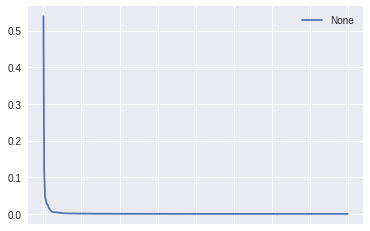

In [0]:
pd.Series(rf.feature_importances_ ,index = X_train.columns).sort_values(ascending=False).plot(legend = True)

In [0]:
importances =  np.sort(rf.feature_importances_)

std = np.sort(np.std([tree.feature_importances_ for tree in  rf.estimators_],
             axis=0))

# test = np.sort(importances[indices].astype(float))
# test

indices = np.argsort(importances)[::-1]

# Print the feature ranking
# I choose only 0.005 in order to manage less data for theexsample.
# In real life i'd choose at least 0.001 (it is a business decision)
print("Feature ranking:")

for f in range(X_train.shape[1]):
  if importances[indices[f]] > 0.005 :
     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

 
 

Feature ranking:
1. feature 400 (0.539075)
2. feature 399 (0.115067)
3. feature 398 (0.048062)
4. feature 397 (0.039608)
5. feature 396 (0.030650)
6. feature 395 (0.024704)
7. feature 394 (0.024196)
8. feature 393 (0.016222)
9. feature 392 (0.013830)
10. feature 391 (0.010274)
11. feature 390 (0.009128)
12. feature 389 (0.006361)
13. feature 388 (0.005335)
14. feature 387 (0.005017)


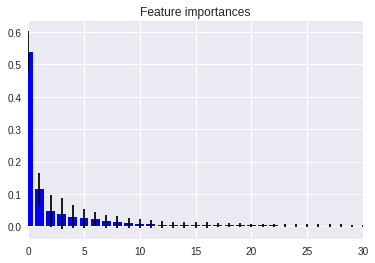

In [0]:

# Plot the feature importances of the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color='b', yerr=std[indices], align="center")
plt.xlim([0,30])
plt.show()


!!!! use the feature importantce for the new calculation  -- pending

In [0]:
X_train_dummies = pd.get_dummies(X_train)
X_test_dummies = pd.get_dummies(X_test)
X_train_dummies.shape
X_test_dummies.shape

(438, 401)

## pipeline, fit and predict

In [0]:
steps = [('scale', preprocessing.StandardScaler()),
         ('select', feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=40)),
        ('PCA', decomposition.PCA(15)),
        ('model', linear_model.Lasso(alpha=10, max_iter=50000))]

pipe = pipeline.Pipeline(steps)

In [0]:
pipe.fit(X_train_dummies, y_train)
y_train_pred = pipe.predict(X_train_dummies)
print(f'train rmse = {rmsle(y_train, y_train_pred.round(2)):.5f}')

train rmse = 0.16503


In [0]:
y_test_pred = pipe.predict(X_test_dummies)
print(f'test rmse = {rmsle(y_test, y_test_pred.round(2)):.5f}')

test rmse = 0.17195


## Feature Engineering

In [0]:
# train.columns
cat_train = train[['Neighborhood','YearBuilt','YearRemodAdd',\
                   'GarageCars','PoolArea','LotArea','TotalBsmtSF',\
                  '1stFlrSF', '2ndFlrSF','YrSold','SalePrice',\
                   'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr']]

In [0]:
#Convert some columnsto boolean data 
cat_train['Garage']  = np.where(cat_train.GarageCars == 0 , '0','1')
cat_train['Pool']  = np.where(cat_train.PoolArea == 0 , '0', '1')
cat_train['Bsmt']  = np.where(cat_train.TotalBsmtSF == 0 , '0', '1')
cat_train['NFloor'] = np.where(cat_train['1stFlrSF'] == 0 , 0 , 1 ) + np.where(cat_train['2ndFlrSF'] == 0 , 0 , 1 )
cat_train['Bath'] = np.where(cat_train['FullBath'] == 0 , 0 , 1 ) + np.where(cat_train['HalfBath'] == 0 , 0 , 1 )
# cat_train

### New features exploration 

In [0]:
#investigate the new features
# Activity per qty 
cat_train.BedroomAbvGr.value_counts().plot.bar() 
()

## pipeline, fit and predict